In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
TEST_DATA_PATH = "/Users/phil/philclarkphd/sleep/model_artifacts/XGBoost_1.2.3-test/XGBoost_1.2.3-test_test_data.csv"

df_test = pd.read_csv(TEST_DATA_PATH, index_col="Unnamed: 0")
df_test.head()

,EEG_quantile_80,EEG_ptp,EEG_ss,EMG_std,EMG_events,EMG_ptp,delta_rel,theta_rel,theta_over_delta,score,predicted_score,predicted_score_filtered
27468,1.166667,1.160714,1.517546,0.818904,5.0,0.866667,0.141835,0.118499,0.835476,Wake,Wake,Wake
27469,1.500000,1.285714,1.918381,0.908051,11.0,0.866667,0.175871,0.112239,0.638188,Wake,Wake,Wake
27470,1.666667,1.267857,2.013400,1.799994,29.0,2.233333,0.326238,0.123734,0.379276,Wake,Wake,Wake
27471,1.500000,1.839286,2.436289,0.997402,15.0,1.100000,0.330713,0.104111,0.314808,Wake,Wake,Wake
27472,1.666667,1.946429,2.287505,1.596668,37.0,1.466667,0.523284,0.121347,0.231895,Wake,Wake,Wake


In [3]:
# Load scores from Mora and see wtf is goin on over der

In [3]:
import sys
import os

# Get the project root directory
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

# Now import your module
import data_processing.sleep_functions as sleep

In [4]:
# load model
import joblib

model_artifact_path = "/Users/phil/philclarkphd/sleep/model_artifacts/XGBoost_1.2.3-test/XGBoost_1.2.3-test.pkl"

model, params, label_encoder = joblib.load(model_artifact_path)

In [5]:
# load data
from scipy.io import wavfile
wav_path = "/Users/phil/philclarkphd/sleep/training_data/sophie/2025-01-03/SPR11/SPR11_AD1.wav"

seconds_per_epoch = 10_000
samplerate, data = wavfile.read(wav_path)
array_size = samplerate * seconds_per_epoch
df = pd.DataFrame(data=data, columns=["eeg", "emg"])

In [6]:
# score data

fs = sleep.generate_features(df, 833)
features = fs[
            [
                "EEG_quantile_80",
                "EEG_ptp",
                "EEG_ss",
                "EMG_std",
                "EMG_events",
                "EMG_ptp",
                "delta_rel",
                "theta_rel",
                "theta_over_delta",
            ]
        ]

predictions = model.predict(features)
decoded_predictions = label_encoder.inverse_transform(predictions)

In [17]:
# compare filtered and unfiltered scores
pred = pd.Series(decoded_predictions)
pred_filtered = sleep.apply_rule_based_filter(pred)

In [18]:
# load scores
scores = pd.read_csv("/Users/phil/philclarkphd/sleep/training_data/sophie/2025-01-03/SPR11/SPR11_AD1_scores.txt")
scores.head()

,epoch,score
0,0,Wake
1,1,Wake
2,2,Wake
3,3,Wake
4,4,Wake


In [19]:
df = pd.DataFrame(pred, columns=["pred"])
df["pred_filtered"] = pred_filtered
df = df.loc[:7913] # cut off because scores are cut off too? Sophie may not have completed scoring
df.shape

(7914, 2)

In [20]:
df["score"] = scores["score"]

In [21]:
df.loc[650:700]

,pred,pred_filtered,score
650,Wake,Wake,Wake
651,Wake,Wake,Wake
652,Wake,Wake,Wake
653,Wake,Wake,Wake
654,Wake,Wake,Wake
655,Wake,Wake,Wake
656,Wake,Wake,Wake
657,Wake,Wake,Wake
658,Wake,Wake,Wake
659,Wake,Wake,Wake


In [23]:
from sklearn.metrics import f1_score

pred_f1 = f1_score(df.score, df.pred, average='weighted')
pred_filtered_f1 = f1_score(df.score, df.pred_filtered, average='weighted')

In [24]:
pred_f1

0.879551846303158

In [25]:
pred_filtered_f1

0.9070780091887553

array([[3054,   84,  238],
       [  50,  293,   28],
       [ 552,    6, 3609]])

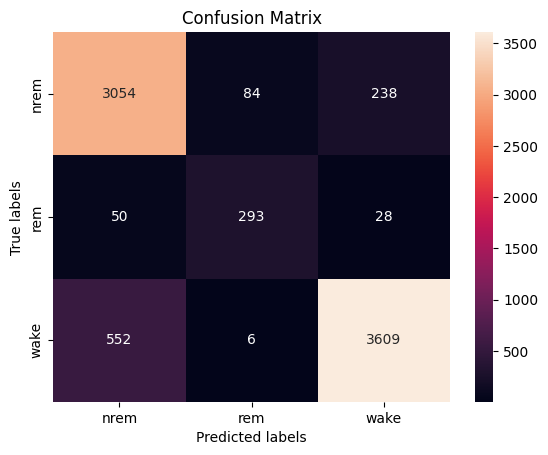

In [26]:
sleep.plot_confusion_matrix(df.score, df.pred, label_list=['nrem','rem','wake'])

array([[3150,   57,  169],
       [  46,  303,   22],
       [ 442,    2, 3723]])

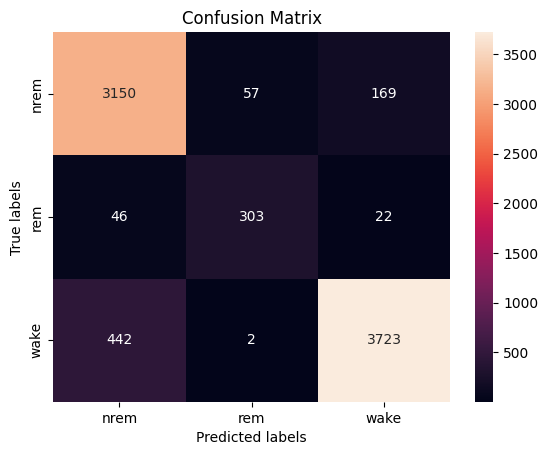

In [27]:
sleep.plot_confusion_matrix(df.score, df.pred_filtered, label_list=['nrem','rem','wake'])